# Лабораторная работа №2 — Линейные модели
## Вариант 3: Регрессия и Классификация

**Цель работы:** изучить применение линейной и логистической регрессии для решения практических задач машинного обучения.

**Датасеты:**
- `auto-mpg.csv` — прогноз расхода топлива (регрессия)
- `pima-indians-diabetes.csv` — диагностика диабета (классификация)


## Часть 1. Регрессия — прогноз расхода топлива (Auto MPG)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Загрузка данных
auto = pd.read_csv('auto-mpg.csv')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


### Предобработка данных
Проверим наличие пропусков и категориальных признаков, удалим строки с отсутствующими значениями в `horsepower`.

In [3]:
# Обработка пропусков
auto.replace('?', np.nan, inplace=True)
auto.dropna(subset=['horsepower'], inplace=True)
auto['horsepower'] = auto['horsepower'].astype(float)

# Выбираем нужные признаки
X = auto[['cylinders', 'horsepower', 'weight']]
y = auto['mpg']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели линейной регрессии
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Предсказания
y_pred = lin_reg.predict(X_test)

# Метрики
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R²: {r2:.3f}')

MSE: 17.68
R²: 0.654


### Визуализация зависимости `mpg` от `horsepower`

/home/mark/Рабочий стол/уник/3 курс 1-й семестр/OMO/ml_as65/reports/Осовец/ЛР2/src/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


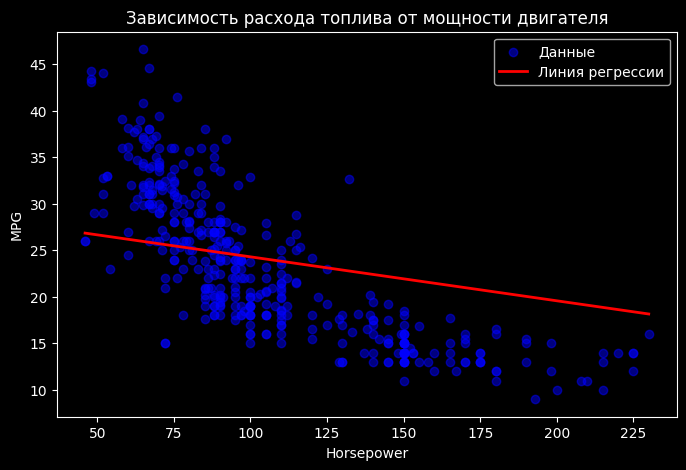

In [4]:
plt.figure(figsize=(8,5))
plt.scatter(auto['horsepower'], auto['mpg'], color='blue', alpha=0.5, label='Данные')
hp_range = np.linspace(auto['horsepower'].min(), auto['horsepower'].max(), 100).reshape(-1,1)
mpg_pred_line = lin_reg.predict(np.c_[np.full_like(hp_range, 4), hp_range, np.full_like(hp_range, 3000)])
plt.plot(hp_range, mpg_pred_line, color='red', linewidth=2, label='Линия регрессии')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Зависимость расхода топлива от мощности двигателя')
plt.legend()
plt.show()

**Вывод:**
Модель линейной регрессии показывает, как мощность и вес автомобиля влияют на расход топлива. Отрицательная зависимость между `horsepower` и `mpg` говорит о том, что с увеличением мощности расход топлива возрастает.

## Часть 2. Классификация — диагностика диабета (Pima Indians Diabetes)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Загрузка данных
diabetes = pd.read_csv('pima-indians-diabetes.csv', comment='#')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Подготовка данных и стандартизация признаков

In [6]:
# Разделение признаков и целевой переменной
X = diabetes.drop('Outcome', axis=1)
y = diabetes['Outcome']

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Обучение логистической регрессии
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Предсказания
y_pred = log_reg.predict(X_test)

# Метрики
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print(f'Accuracy: {acc:.3f}')
print(f'Precision: {prec:.3f}')
print(f'Recall: {rec:.3f}')

Accuracy: 0.753
Precision: 0.649
Recall: 0.673


### Матрица ошибок

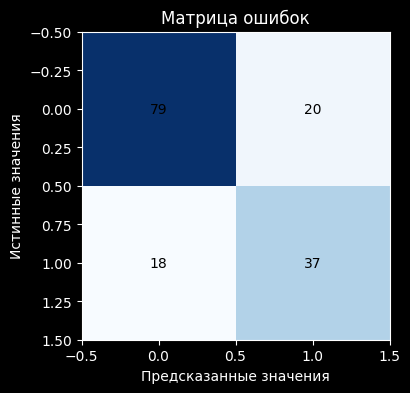

In [7]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap='Blues')
ax.set_xlabel('Предсказанные значения')
ax.set_ylabel('Истинные значения')
ax.set_title('Матрица ошибок')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

**Вывод:**
Модель логистической регрессии адекватно классифицирует наличие диабета. Ложноположительные срабатывания означают, что модель ошибочно определила диабет у здорового человека, а ложноотрицательные — пропустила болезнь.